# Tutorial CV3 - Function fitting with a quantum neural network

In this tutorial we show how a variational circuit can be used to extrapolate a one-dimensional function when being trained with noisy samples from that function. 

The variational circuit we use is the continuous-variable quantum neural network model described in Killoran et al. 2018 (arxiv 1806.06871). 

### Imports

This time we will use the Adam optimizer. 

*Note: For convenience, we use Penny Lane's numpy library for all numpy processing. Strictly speaking, one only needs this library for numpy operations inside the cost function or functions called therein, and can use numpy imported via the usual `import numpy as np` everywhere else.*

In [1]:
import pennylane as qm
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

The device we use is the Strawberry Fields simulator, this time with only one quantum mode or "wire". You need to have the Strawberry Fields plugin to Penny Lane installed.

In [2]:
try:
    dev = qml.device('strawberryfields.fock', wires=1, cutoff_dim=10)    
    
except:
    print("To run this tutorial you need to install the strawberryfields plugin...")

### Quantum node

A single mode layer of the variational circuit is defined as:

In [3]:
def layer(v):

    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=[0])
    qml.Squeezing(v[1], 0., wires=[0])
    qml.Rotation(v[2], wires=[0])

    # Bias
    qml.Displacement(v[3], 0., wires=[0])

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], [0])

The variational circuit in the quantum node first encodes the input into the displacement of the mode, and then executes the layers. The output is the expectation of the x-quadrature.

In [4]:
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    
    # Encode input x into quantum state
    qml.Displacement(x, 0., wires=[0])

    # execute "layers"
    for v in var:
        layer(v)

    return qml.expval.X(0)

### Objective

As an objective we take the square loss between target labels and model predictions.

In [5]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l-p)**2
    loss = loss/len(labels)

    return loss

In the cost function, we compute the outputs from the variational circuit. Function fitting is a regression problem, and we interpret the expectations from the quantum node as predictions (i.e. without applying postprocessing such as thresholding).

In [6]:
def cost(var, features, labels):

    preds = [quantum_neural_net(var, x=x) for x in features]

    return square_loss(labels, preds)

### Optimization

We load noisy data samples of a sine function.

In [7]:
data = np.loadtxt("sine.txt")
X = data[:, 0]
Y = data[:, 1]

The data looks as follows. 

*Note: For the next cell to work you need python's matplotlib library.* 

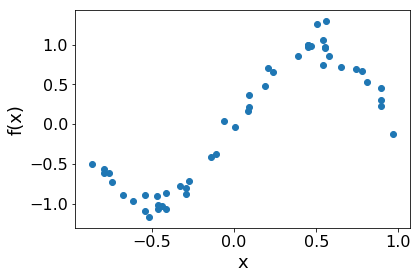

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure()
plt.scatter(X, Y)
plt.xlabel('x', fontsize=18)
plt.ylabel('f(x)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.show()

The network's weights, which we call variables here, are initialized with values sampled from a normal distribution. We use 4 layers, although performance has been found to plateau at around 6 layers.

In [9]:
num_layers = 4
var_init = 0.05*np.random.randn(num_layers, 7)

var_init

array([[-0.00059975,  0.02703709,  0.10753069, -0.01404406,  0.00701316,
        -0.09267455, -0.01636058],
       [ 0.00736721,  0.02360485, -0.06415404,  0.10136537,  0.09282207,
        -0.12027798,  0.03443421],
       [-0.0473637 ,  0.04568577,  0.03190277, -0.03296799,  0.00394201,
         0.0368665 , -0.02131034],
       [-0.02192684,  0.01490227,  0.04251858, -0.04899001, -0.10825417,
        -0.02728108,  0.05813111]])

We choose the Adam optimizer and update the weights for 10 steps.

In [10]:
o = AdamOptimizer(0.005, beta1=0.9, beta2=0.999)

var = var_init
for it in range(10):
    var = o.step(lambda v: cost(v, X, Y), var)
    
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it+1, cost(var, X, Y)))

Iter:     1 | Cost: 0.3090922 
Iter:     2 | Cost: 0.3032331 
Iter:     3 | Cost: 0.2978827 
Iter:     4 | Cost: 0.2925242 
Iter:     5 | Cost: 0.2868469 
Iter:     6 | Cost: 0.2806203 
Iter:     7 | Cost: 0.2736549 
Iter:     8 | Cost: 0.2657934 
Iter:     9 | Cost: 0.2569197 
Iter:    10 | Cost: 0.2469741 


We can continue training for another 50 steps (although this takes some time).

In [11]:
for it in range(40):
    var = o.step(lambda v: cost(v, X, Y), var)
    
    print("Iter: {:5d} | Cost: {:0.7f}".format(it+11, cost(var, X, Y)))

Iter:    11 | Cost: 0.2359730
Iter:    12 | Cost: 0.2240299
Iter:    13 | Cost: 0.2113741
Iter:    14 | Cost: 0.1983652
Iter:    15 | Cost: 0.1854955
Iter:    16 | Cost: 0.1733741
Iter:    17 | Cost: 0.1626840
Iter:    18 | Cost: 0.1541021
Iter:    19 | Cost: 0.1481801
Iter:    20 | Cost: 0.1451937
Iter:    21 | Cost: 0.1449971
Iter:    22 | Cost: 0.1469549
Iter:    23 | Cost: 0.1500366
Iter:    24 | Cost: 0.1530849
Iter:    25 | Cost: 0.1551347
Iter:    26 | Cost: 0.1556214
Iter:    27 | Cost: 0.1544181
Iter:    28 | Cost: 0.1517488
Iter:    29 | Cost: 0.1480526
Iter:    30 | Cost: 0.1438493
Iter:    31 | Cost: 0.1396313
Iter:    32 | Cost: 0.1357891
Iter:    33 | Cost: 0.1325718
Iter:    34 | Cost: 0.1300786
Iter:    35 | Cost: 0.1282778
Iter:    36 | Cost: 0.1270411
Iter:    37 | Cost: 0.1261868
Iter:    38 | Cost: 0.1255199
Iter:    39 | Cost: 0.1248645
Iter:    40 | Cost: 0.1240840
Iter:    41 | Cost: 0.1230917
Iter:    42 | Cost: 0.1218512
Iter:    43 | Cost: 0.1203712
Iter:    4

Finally, we collect the predictions of the trained model for 50 values in $[-1,1]$...

In [12]:
x_pred = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(var, x=x_) for x_ in x_pred]

...and plot the shape of the function that the model has "learned" from the noisy data (green dots).

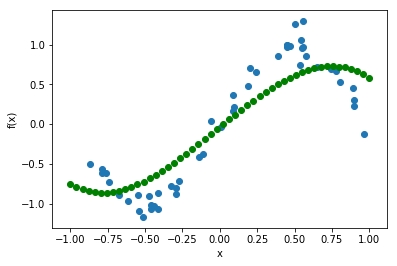

In [13]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color='green')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.show()

The model has learned to smoothen the noisy data.

In fact, we can use Penny Lane to look at typical functions that the model produces without being trained at all. The shape of these functions varies significantly with the variance hyperparameter for the weight initialization. 

Setting this hyperparameter to a small value produces almost linear functions, since all quantum gates in the variational circuit are almost performing an identity. Larger values produces smoothly oscillating functions with a period that depends on the number of layers used (the more layers the smaller the period).

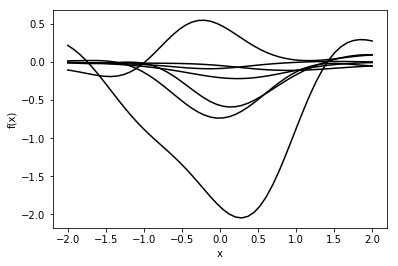

In [14]:
variance = 1.

plt.figure()
x_pred = np.linspace(-2, 2, 50)
for i in range(7):
    rnd_var = variance*np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x=x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color='black')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.show()